# Lending Club Project

I will go through a step-by-step workflow to determine loan deliquency. Predictions are made based on the information available at the time the loan was issued. Our data is a portion of the public Lending Club dataset.

### WorkFlow

1. Start H2O cluster
2. Load data
3. Pre-process data
4. Feature engineering
5. Model training
6. Examine model accuracy
7. Interpret model
8. Save and reuse model
9. AutoML (optional)
10. Stop H2O-3 cluster

## 1. Initialize H2O cluster

In [251]:
# Import necessary packages
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Initialize instance of H2O
h2o.init(bind_to_localhost=False)  # run and expose the cluster to the Internet

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from D:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\jay48\AppData\Local\Temp\tmpfhxaouyl
  JVM stdout: C:\Users\jay48\AppData\Local\Temp\tmpfhxaouyl\h2o_jay48_started_from_python.out
  JVM stderr: C:\Users\jay48\AppData\Local\Temp\tmpfhxaouyl\h2o_jay48_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.1.2
H2O cluster version age:,2 months and 21 days
H2O cluster name:,H2O_from_python_jay48_bauh5p
H2O cluster total nodes:,1
H2O cluster free memory:,3.951 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


## 2. Load Data

Data: https://s3-us-west-2.amazonaws.com/h2o-tutorials/data/topics/lending/lending_club/LoanStats3a.csv

Desc: https://www.kaggle.com/pragyanbo/a-hitchhiker-s-guide-to-lending-club-loan-data/notebook

In [252]:
file_path = 'http://h2o-public-test-data.s3.amazonaws.com/bigdata/laptop/lending-club/LoanStats3a.csv'

# Specify some column types to "String" that we want to munge later
types = {"int_rate":"string", "revol_util":"string", "emp_length":"string", "verification_status":"string"}

# Load data
loans = h2o.import_file(path = file_path, col_types = types)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [254]:
# Save data to local
h2o.export_file(loans, path = '../../Data/Lending_Club.csv')

In [255]:
print('Data Dimension:', loans.shape)
loans.head(1)

Data Dimension: (42538, 52)


id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code
1.0775e+06,1.2966e+06,5000,5000,4975,36 months,10.65%,162.87,B,B2,,10+ years,RENT,24000,VERIFIED - income,2011-12-01 00:00:00,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail.action?loan_id=1077501,Borrower added on 12/22/11 > I need to upgrade my business technologies.,credit_card,Computer,860xx,AZ,27.65,0,1985-01-01 00:00:00,1,,,3,0,13648,83.7%,9,f,0,0,5861.07,5831.78,5000,861.07,0,0,0,2015-01-01 00:00:00,171.62,,2015-01-01 00:00:00,0,,1


## 3.  Pre-process Data

### 3.1. Define Target Variable

Drop all loans that are still in progess and therefore cannot be deemed good/bad loans. My response column will be called: bad_loan. The bad_loan column will be positive if the loan was not completely paid off.

In [256]:
loans['loan_status'].table()

loan_status,Count
Charged Off,5435
Current,3351
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843
In Grace Period,60
Late (16-30 days),16


In [257]:
ongoing_status = ['Current', 'In Grace Period', 'Late (16-30 days)', 'Late (31-120 days)']
df = loans[~loans['loan_status'].isin(ongoing_status)]

print('Data Dimension:', loans.shape)
df['loan_status'].table()

Data Dimension: (42538, 52)


loan_status,Count
Charged Off,5435
Default,7
Does not meet the credit policy. Status:Charged Off,761
Does not meet the credit policy. Status:Current,53
Does not meet the credit policy. Status:Fully Paid,1933
Does not meet the credit policy. Status:In Grace Period,2
Fully Paid,30843


In [258]:
# Define target variables
df['bad_loan'] = ~(df['loan_status'] == 'Fully Paid')

# Label distribution
bad_loan_dist = df['bad_loan'].table()
bad_loan_dist['perc'] = bad_loan_dist['Count'] / df.nrow
print(bad_loan_dist)

# Label encoding
df['bad_loan'] = df['bad_loan'].asfactor()

bad_loan,Count,perc
0,30843,0.790097
1,8194,0.209903


### 3.2. Data Cleaning

I notice that multiple columns are numeric, but are being treated as string because of their syntax, so I will convert these to numeric.

In [259]:
df[["int_rate", "revol_util", "emp_length"]].head()

int_rate,revol_util,emp_length
10.65%,83.7%,10+ years
15.27%,9.4%,< 1 year
15.96%,98.5%,10+ years
13.49%,21%,10+ years
7.90%,28.3%,3 years
18.64%,87.5%,9 years
21.28%,32.6%,4 years
12.69%,36.5%,< 1 year
14.65%,20.6%,5 years
12.69%,67.1%,10+ years


In [260]:
# Remove %
df['int_rate'] = df['int_rate'].gsub(pattern = '%', replacement = '')
df['revol_util'] = df['revol_util'].gsub(pattern = '%', replacement = '')

# Use trim to remove any trailing spaces
df['int_rate'] = df['int_rate'].trim()
df['revol_util'] = df['revol_util'].trim()

# Convert int_rate to numeric
df['int_rate'] = df['int_rate'].asnumeric()
df['revol_util'] = df['revol_util'].asnumeric()

Use the `hist` function to see the distribution of interest rate for good loans and bad loans. I found that the distribution of interest rate is very different for good loans, so this may be a helpful predictor in my model.

Bad Loans


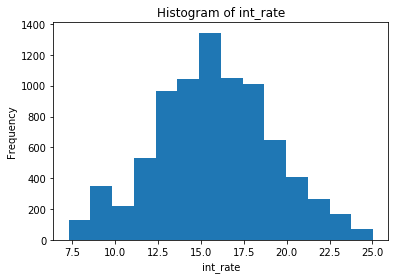

Good Loans


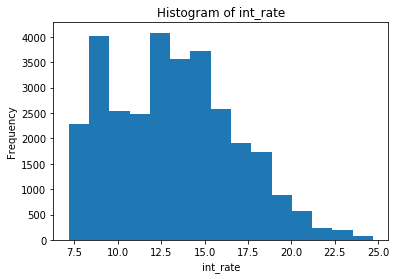

In [261]:
print('Bad Loans')
df[df['bad_loan'] == "1", 'int_rate'].hist()

print('Good Loans')
df[df['bad_loan'] == "0", 'int_rate'].hist()

Bad Loans


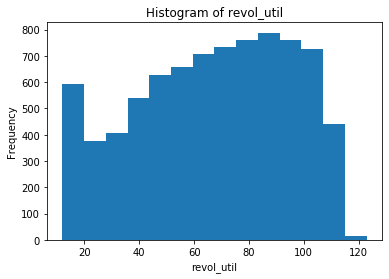

Good Loans


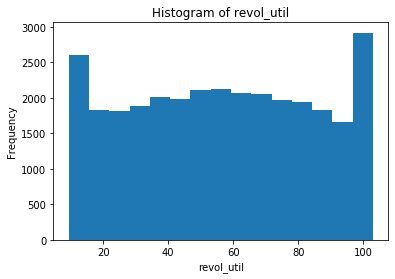

In [262]:
print('Bad Loans')
df[df['bad_loan'] == "1", 'revol_util'].hist()

print('Good Loans')
df[df['bad_loan'] == "0", 'revol_util'].hist()

In [263]:
# Remove " year" and " years" also translate n/a to "" 
df['emp_length'] = df['emp_length'].gsub(pattern = '([ ]*+[a-zA-Z].*)|(n/a)', replacement = '')

# Convert < 1 to 0 years and do the same for 10 + to 10
df['emp_length'] = df['emp_length'].gsub(pattern = '< 1', replacement = '0')
df['emp_length'] = df['emp_length'].gsub(pattern = '10\\+', replacement = '10')


# Use trim to remove any trailing spaces 
df['emp_length'] = df['emp_length'].trim()

# # Convert emp_length to numeric 
df['emp_length'] = df['emp_length'].asnumeric()

df['emp_length'].table()

emp_length,Count
0,4767
1,3376
2,4441
3,4064
4,3366
5,3163
6,2152
7,1708
8,1456
9,1212


I also clean up the verification status column. There are multiple values that mean verified: `VERIFIED - income` and `VERIFIED - income source`.  We will replace these values with `verified`.

In [264]:
df["verification_status"].head()

verification_status
VERIFIED - income
VERIFIED - income source
not verified
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income source
VERIFIED - income
not verified
VERIFIED - income source


In [265]:
df['verification_status'] = df['verification_status'].sub(pattern = 'VERIFIED - income source', replacement = 'verified')
df['verification_status'] = df['verification_status'].sub(pattern = 'VERIFIED - income', replacement = 'verified')
df['verification_status'] = df['verification_status'].asfactor()
df['verification_status']

verification_status
verified
verified
not verified
verified
verified
verified
verified
verified
not verified
verified


## 4.  Feature engineering

After cleaning data, I can add some new features to our data that may help improve the performance of our supervised learning models.

The new features we will create are: 
* `credit_length`: the time from their earliest credit line to when they were issued the loan
* `issue_d_year` and `issue_d_month`: extract year and month from the issue date
* word embeddings from the loan description

### 4.1. Credit Length

I can extract the credit length by subtracting the year they had their earliest credit line from the year when they issued the loan.

In [266]:
df['credit_length'] = df['issue_d'].year() - df['earliest_cr_line'].year()
df['credit_length'].head()

credit_length
26
12
10
15
7
4
7
7
13
22


### 4.2. Issue Date Expansion

I extract the year and month from the issue date, and find that the month or the year when the loan was issued can impact the probability of a bad loan. I will treat `year` as numeric, while `month` as categorical.

In [267]:
df['issue_d_year'] = df['issue_d'].year()
df['issue_d_month'] = df['issue_d'].month().asfactor()

In [268]:
df[['issue_d_year', 'issue_d_month']].head()

issue_d_year,issue_d_month
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12
2011,12


### 4.3. Word Embeddings

One of the columns in our dataset is a description of why the loan was requested. The first few descriptions in the dataset are shown below.

In [269]:
loans["desc"].head()

desc
Borrower added on 12/22/11 > I need to upgrade my business technologies.
Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike. I only need this money because the deal im looking at is to good to pass up. Borrower added on 12/22/11 > I plan to use this money to finance the motorcycle i am looking at. I plan to have it paid off as soon as possible/when i sell my old bike.I only need this money because the deal im looking at is to good to pass up. I have finished college with an associates degree in business and its takingmeplaces
""
"Borrower added on 12/21/11 > to pay for property tax (borrow from friend, need to pay back) & central A/C need to be replace. I'm very sorry to let my loan expired last time."
"Borrower added on 12/21/11 > I plan on combining three large interest bills together and freeing up some extra each month to pay toward other bills. I've always been a good payor but have found myself needing to make adjustments to my budget due to a medical scare. My job is very stable, I love it."
""
"Borrower added on 12/18/11 > I am planning on using the funds to pay off two retail credit cards with 24.99% interest rates, as well as a major bank credit card with a 18.99% rate. I pay all my bills on time, looking for a lower combined payment and lower monthly payment."
Borrower added on 12/16/11 > Downpayment for a car.
Borrower added on 12/21/11 > I own a small home-based judgment collection business. I have 5 years experience collecting debts. I am now going from a home office to a small office. I also plan to buy a small debt portfolio (eg. $10K for $1M of debt) My score is not A+ because I own my home and have no mortgage.
"Borrower added on 12/16/11 > I'm trying to build up my credit history. I live with my brother and have no car payment or credit cards. I am in community college and work full time. Im going to use the money to make some repairs around the house and get some maintenance done on my car. Borrower added on 12/20/11 > $1000 down only $4375 to go. Thanks to everyone that invested so far, looking forward to surprising my brother with the fixes around the house."


This information may be important to the model but supervised learning algorithms have a hard time understanding text.  Instead we will convert these strings to a numeric vector using the Word2Vec algorithm.

In [270]:
STOP_WORDS = ["ax","i","you","edu","s","t","m","subject","can","lines","re","what",
              "there","all","we","one","the","a","an","of","or","in","for","by","on",
              "but","is","in","a","not","with","as","was","if","they","are","this","and","it","have",
              "from","at","my","be","by","not","that","to","from","com","org","like","likes","so"]

In [271]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [272]:
# Break loan description into sequence of words
words = tokenize(df['desc'].ascharacter())

In [273]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator

w2v_model = H2OWord2vecEstimator(vec_size=100, model_id="w2v")
w2v_model.train(training_frame=words)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [274]:
# Sanity check - find synonyms for the word 'car'
w2v_model.find_synonyms('car', count = 5)

OrderedDict([('auto', 0.7672295570373535),
             ('vehicle', 0.7595592141151428),
             ('camry', 0.7574484944343567),
             ('prius', 0.7044962644577026),
             ('acura', 0.6783682107925415)])

In [275]:
# Calculate a vector for each description
desc_vecs = w2v_model.transform(words, aggregate_method = 'AVERAGE')

In [276]:
desc_vecs.head()

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0776993,-0.139029,0.118961,-0.0383549,0.15223,0.164481,-0.0602325,0.174013,-0.256112,-0.0851185,-0.0843648,0.153515,-0.203846,-0.0880585,-0.132882,0.0962877,0.218473,0.107696,-0.026704,0.0396209,0.108452,0.0462704,-0.159488,0.0722751,-0.220153,-0.0926195,-0.0867673,0.112381,0.0750305,-0.364603,-0.305942,0.018374,0.0314561,0.0209167,0.0428785,-0.0977699,0.0675875,-0.0465388,-0.0770288,0.0161066,0.109509,-0.0817511,0.0373905,-0.00305598,-0.0274596,0.0612951,-0.240027,-0.00231828,0.0443818,-0.174974,0.225324,-0.00606963,0.0201159,0.0463736,-0.0488498,0.0384262,-0.0294587,-0.276177,-0.184975,0.0716571,-0.17055,0.122089,-0.188507,-0.116475,-0.0111559,-0.0555811,0.104761,0.127593,0.100088,-0.0688614,0.0577088,0.0108682,0.117227,0.0378469,-0.0157436,0.159353,-0.1417,-0.158667,-0.0974994,-0.0435252,0.0251483,0.0237428,-0.026001,0.0422047,0.08016,-0.136419,-0.010913,0.0880791,-0.0542445,-0.136867,-0.10818,0.0871018,-0.125098,0.00415255,0.210126,-0.0322812,-0.0190765,0.240256,0.104527,0.0848087
-0.159077,-0.110835,0.05741,-0.0678771,-0.000600793,0.22642,0.0415689,0.291838,-0.173753,0.0453615,-0.0488291,0.126732,-0.0567782,-0.0637515,-0.0103402,0.113733,0.17796,-0.191185,-0.0482294,0.168826,0.110948,0.063675,-0.183146,0.0614727,-0.133625,-0.066238,-0.0326877,0.118277,-0.0216852,-0.292702,-0.19435,-0.0985782,-0.0841358,0.0786964,-0.0800762,-0.162374,0.0868905,-0.0747126,-0.0357995,0.0766279,0.0522231,-0.0829177,0.0178229,-0.0499931,-0.0905615,-0.0445783,-0.16129,-0.0951008,0.205344,-0.00377113,0.140515,-0.0131464,0.0252334,-0.0356184,0.113841,-0.00737701,0.0249862,-0.0999584,-0.130393,-0.0222024,-0.222085,0.147722,-0.00273405,-0.0594776,-0.0639463,-0.0578745,0.0205901,0.0207452,0.0195417,0.0356413,0.0772375,-0.090065,-0.039169,0.036861,-0.0153336,0.0669377,-0.0932103,-0.114715,-0.0648066,-0.0777988,-0.0255353,-0.0657572,-0.0539299,0.037725,-0.00285868,-0.153127,0.143695,0.149026,-0.0711126,-0.0505124,-0.189589,-0.0263304,-0.11612,0.00793401,0.156429,-0.034836,-0.0782278,0.0796792,0.0267303,-0.0494615
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
-0.147202,-0.0775678,0.0309489,0.0162149,-0.0621894,0.249468,0.0342216,0.256231,-0.166183,0.0722434,-0.0795619,0.013062,-0.0181671,-0.0471078,-0.0645905,0.0130309,0.0901722,-0.181949,-0.0877777,0.0472166,0.112732,0.0852372,-0.188873,0.0292249,-0.187743,-0.117198,0.00298991,0.12574,-0.0235894,-0.288799,-0.162562,-0.00317456,-0.0607117,0.0939057,-0.0973316,-0.0656414,0.0586031,-0.158069,-0.0276538,0.0726007,0.0200516,-0.0814889,0.0233115,-0.00945385,-0.0831677,0.0357451,-0.109995,-0.0861448,0.170634,-0.0445463,0.21818,-0.0608222,-0.0065488,-0.00892453,0.167784,0.0371501,-0.00789941,-0.201636,-0.110565,0.0236789,-0.204743,0.154457,-0.0170374,-0.111626,-0.0298884,-0.0702723,0.171143,0.00647368,0.057974,-0.0109773,0.197844,-0.0730395,0.0840138,-0.0322204,-0.011649,0.0765146,-0.0488931,-0.202335,-0.119367,-0.0587861,0.0194811,-0.0979673,0.0252138,0.0490004,-0.0266297,-0.0687084,0.0464444,0.113027,-0.158289,-0.00123888,-0.146289,-0.0293312,0.00859693,0.0300616,0.206539,-0.0459738,0.0579879,0.125382,0.151334,-0.0480735
nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,na

In [277]:
# Add aggregated word embeddings 
df = df.cbind(desc_vecs)

### 5. Model training

In [278]:
train, test = df.split_frame(seed=25, ratios=[0.75])

In [279]:
from h2o.estimators import H2OGradientBoostingEstimator

y = 'bad_loan'
x = ['emp_title','issue_d_year','issue_d_month','pymnt_plan','term','title','pub_rec','revol_util','int_rate','addr_state','open_acc','total_acc','verification_status',
     'annual_inc','revol_bal','inq_last_6mths','issue_d_year','earliest_cr_line','issue_d_month','sub_grade','purpose','grade',
     'emp_length','dti','delinq_2yrs','url','loan_amnt','installment','home_ownership']

In [287]:
gbm_model = H2OGradientBoostingEstimator(stopping_metric='logloss',
                                         stopping_rounds= 5,
                                         score_tree_interval=5,
#                                          max_depth=7,
                                         ntrees=200,
                                         learn_rate=0.05,
                                         sample_rate=0.9,
                                         col_sample_rate=0.9,
                                         balance_classes=False,
                                         model_id="GBM_BadLoan",
                                         nfolds=5,
                                         seed=25,
                                         fold_assignment='stratified')

gbm_model.train(x=x, y=y, training_frame=train, validation_frame=test)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


# Step 7 (of 10).  Examine model accuracy

The plot below shows the performance of the model as more trees are built.  This graph can help us see if our model is overfitting.  Our early stopping kicked in at 100 trees.  This is where the model was no longer improving performance on the test data.

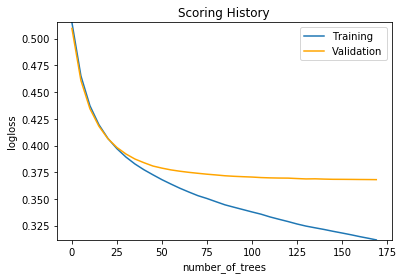

In [288]:
%matplotlib inline
gbm_model.plot()

In [289]:
gbm_model.confusion_matrix()


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.316420534145825: 


,,0,1,Error,Rate
0,0,21807.0,1346.0,0.0581,(1346.0/23153.0)
1,1,2242.0,3948.0,0.3622,(2242.0/6190.0)
2,Total,24049.0,5294.0,0.1223,(3588.0/29343.0)


The ROC curve of the training and testing data are shown below.  The area under the ROC curve is much higher for the training data than the testing data indicating that the model may be beginning to memorize the training data.

Training Data


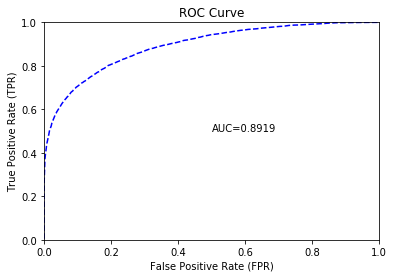

Testing Data


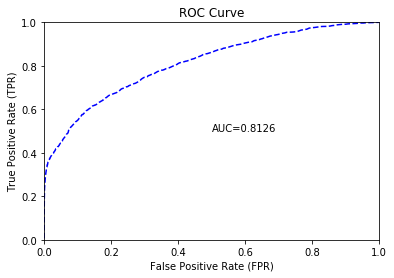

In [290]:
print("Training Data")
gbm_model.model_performance(train = True).plot()
print("Testing Data")
gbm_model.model_performance(valid = True).plot()

## 7. Interpret model

The variable importance plot shows us which variables are most important to predicting `bad_loan`.  We can use partial dependency plots to learn more about how these variables affect the prediction.

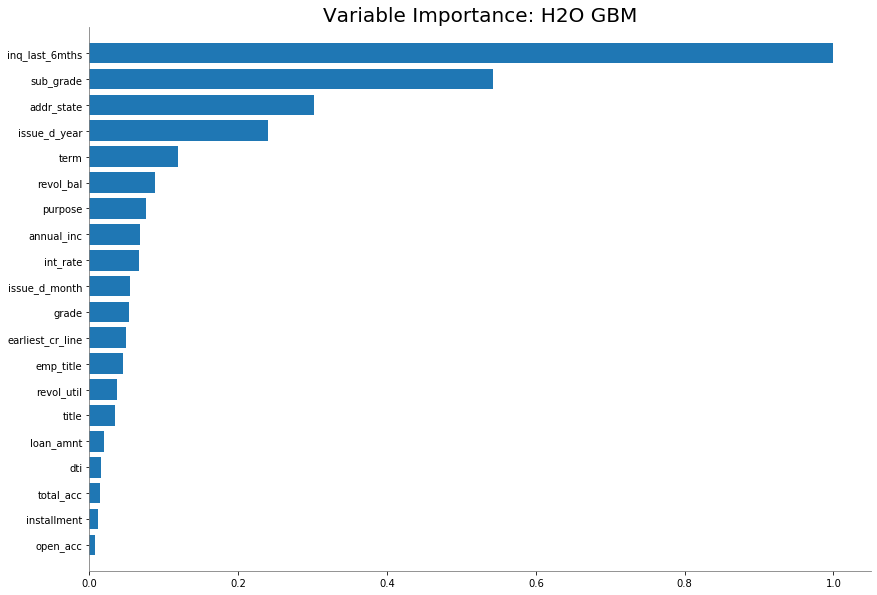

In [291]:
gbm_model.varimp_plot(20)

The partial dependency plot of the `inq_last_6mths` predictor shows us that, as the number of inquiries in the last 6 months increases, the likelihood of the loan defaulting also increases.

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


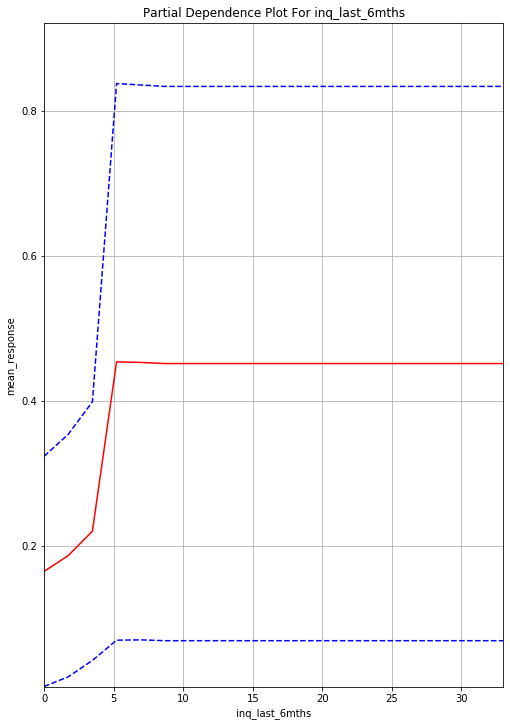

In [292]:
pdp = gbm_model.partial_plot(cols=["inq_last_6mths"], data=train)

In [293]:
df["inq_last_6mths"].table().head(100)

inq_last_6mths,Count
0,17910
1,10288
2,5480
3,2942
4,1022
5,590
6,335
7,181
8,112
9,50


## 8. Save and reuse model

The model can either be embedded into a self-contained Java MOJO/POJO package
or it can be saved and later loaded directly in H2O-3 cluster. For production
use, we recommend to use MOJO as it is optimised for speed. See the [guide](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/productionizing.html) for further information.

### Downloading MOJO

In [ ]:
gbm_model.download_mojo()

### Save and reuse the model 

We can save the model to disk for later batch scoring in H2O cluster.

In [ ]:
model_path = h2o.save_model(model=gbm_model, force=True)
print(model_path)
loaded_model = h2o.load_model(path=model_path)

We can also score new data using the predict function:

In [ ]:
bad_loan_hat = loaded_model.predict(test)
bad_loan_hat.head(15)

## 9. AutoML (optional)
AutoML can be used for automating the machine learning workflow, which includes automatic training and tuning of many models within a user-specified time-limit. Stacked Ensembles will be automatically trained on collections of individual models to produce highly predictive ensemble models.

In [ ]:
from h2o.automl import H2OAutoML

aml = H2OAutoML(max_runtime_secs=300, seed=25)
aml.train(x=predictors, y='bad_loan', training_frame=train)

The leaderboard contains the performance metrics of the models generated by AutoML:

In [ ]:
aml.leaderboard

Since we provided only training frame during training, the models are sorted by their cross-validated performance metrics (AUROC by default for classification). We can evaluate the best model (`leader`) on the test data:

In [ ]:
aml.leader.model_performance(test_data=test).plot()
aml.leader.model_performance(test_data=test)

## 10. Stop H2O-3 cluster

In [245]:
h2o.cluster().shutdown()

H2O session _sid_96f6 closed.
